## Setup

In [1]:
import numpy as np
import pandas as pd

## Load Data

In [2]:
df_train_prompts = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/prompts_train.csv')
df_train_summaries = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv')
df_test_prompts = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/prompts_test.csv')
df_test_summaries = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/summaries_test.csv')

## Build train set

In [3]:
df_train = df_train_summaries.merge(df_train_prompts, on='prompt_id')
df_test = df_test_summaries.merge(df_test_prompts, on='prompt_id')

df_train.head()

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
1,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
2,0095993991fe,814d6b,The third wave only started as an experiment w...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,00c20c6ddd23,814d6b,The experimen was orginally about how even whe...,0.567975,0.969062,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
4,00d40ad10dc9,814d6b,The third wave developed so quickly due to the...,-0.910596,-0.081769,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...


## Add lenght feature

In [4]:

df_train['length_ratio'] = df_train['text'].apply(len) / df_train['prompt_text'].apply(len)
df_test['length_ratio'] = df_test['text'].apply(len) / df_test['prompt_text'].apply(len)


## Add gzip scores

In [5]:
import gzip

In [6]:
def calculate_compressed_size(text):
    # Convert the text to bytes
    text_bytes = text.encode('utf-8')
    
    # Compress the bytes
    compressed_bytes = gzip.compress(text_bytes)
    
    # Return the length of the compressed bytes
    return len(compressed_bytes)

In [7]:
df_train['score'] = df_train['text'].apply(lambda x: len(x) / calculate_compressed_size(x))
df_test['score'] = df_test['text'].apply(lambda x: len(x) / calculate_compressed_size(x))

df_train['paraphrase'] = df_train.apply(lambda row: calculate_compressed_size(row['text'] + row['prompt_text']) / (calculate_compressed_size(row['text']) + calculate_compressed_size(row['prompt_text'])), axis=1)
df_test['paraphrase'] = df_test.apply(lambda row: calculate_compressed_size(row['text'] + row['prompt_text']) / (calculate_compressed_size(row['text']) + calculate_compressed_size(row['prompt_text'])), axis=1)


## Add semantic

In [8]:
import pandas as pd
import torch
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.metrics.pairwise import cosine_similarity

if torch.cuda.is_available():    
    n_gpu = torch.cuda.device_count()
    device_ids = list(range(n_gpu))
    device = torch.device(f'cuda:{device_ids[0]}')  # Choose the first device
    print('There are %d GPU(s) available.' % n_gpu)
    print('We will use the GPUs:', device_ids)
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    device_ids = None

path = '/kaggle/input/distilbert-base-uncased'

# Load tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained(path)
model = DistilBertModel.from_pretrained(path)
model.to(device)  # move the model to GPU or CPU based on availability

if device_ids:
    model = torch.nn.DataParallel(model, device_ids=device_ids) # Wrap the model with DataParallel

import functools

@functools.lru_cache(maxsize=128)
def get_embedding(text):
    inputs = tokenizer(text, max_length=512, truncation=True, padding='max_length', return_tensors='pt')
    if device_ids:
        inputs = {name: tensor.to(device) for name, tensor in inputs.items()}  # move inputs to GPU
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy()  # move the result back to cpu before converting to numpy

# Compute embeddings and similarity score
def get_similarity(row):
    prompt_embedding = get_embedding(row['prompt_text'])
    text_embedding = get_embedding(row['text'])
    similarity = cosine_similarity(prompt_embedding, text_embedding)
    return similarity[0][0]

# Add similarity score to DataFrame
# df_train['similarity_score'] = 0
# df_test['similarity_score'] = 0
df_train['similarity_score'] = df_train.apply(get_similarity, axis=1)
df_test['similarity_score'] = df_test.apply(get_similarity, axis=1)

# Print the DataFrame
df_train.head()


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

There are 2 GPU(s) available.
We will use the GPUs: [0, 1]


Some weights of the model checkpoint at /kaggle/input/distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text,length_ratio,score,paraphrase,similarity_score
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,0.097027,1.565611,0.960753,0.719612
1,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,0.343522,1.896285,0.934792,0.896692
2,0095993991fe,814d6b,The third wave only started as an experiment w...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,0.096747,1.480687,0.939637,0.776793
3,00c20c6ddd23,814d6b,The experimen was orginally about how even whe...,0.567975,0.969062,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,0.126472,1.645985,0.929953,0.781051
4,00d40ad10dc9,814d6b,The third wave developed so quickly due to the...,-0.910596,-0.081769,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,0.040662,1.178862,0.959137,0.640840


## Add synthatic features

In [9]:
def lexical_diversity(text):
    tokens = text.split()
    return len(set(tokens)) / len(tokens) if tokens else 0

def avg_sentence_length(text):
    sentences = text.split('.')
    if '' in sentences: sentences.remove('')
    return sum(len(s.split()) for s in sentences) / len(sentences) if sentences else 0


def add_features(df):
    df['lexical_diversity'] = df['text'].apply(lexical_diversity)
    df['avg_sentence_length'] = df['text'].apply(avg_sentence_length)
    return df

# Apply the function to both the training and test datasets
df_train = add_features(df_train)
df_test = add_features(df_test)


## Feature selection

In [10]:
SYNTAXIC_FEATURES = ["avg_sentence_length","lexical_diversity"]
SEMANTIC_FEATURES = ["similarity_score"]
COMPRESSION_FEATURES = ["length_ratio","paraphrase", "score"]
ALL_FEATURES = COMPRESSION_FEATURES + SEMANTIC_FEATURES + SYNTAXIC_FEATURES
CONTENT_FEATURES = ["length_ratio", "similarity_score", "paraphrase"]
WORDING_FEATURES = ["length_ratio", "similarity_score","avg_sentence_length", "paraphrase"]

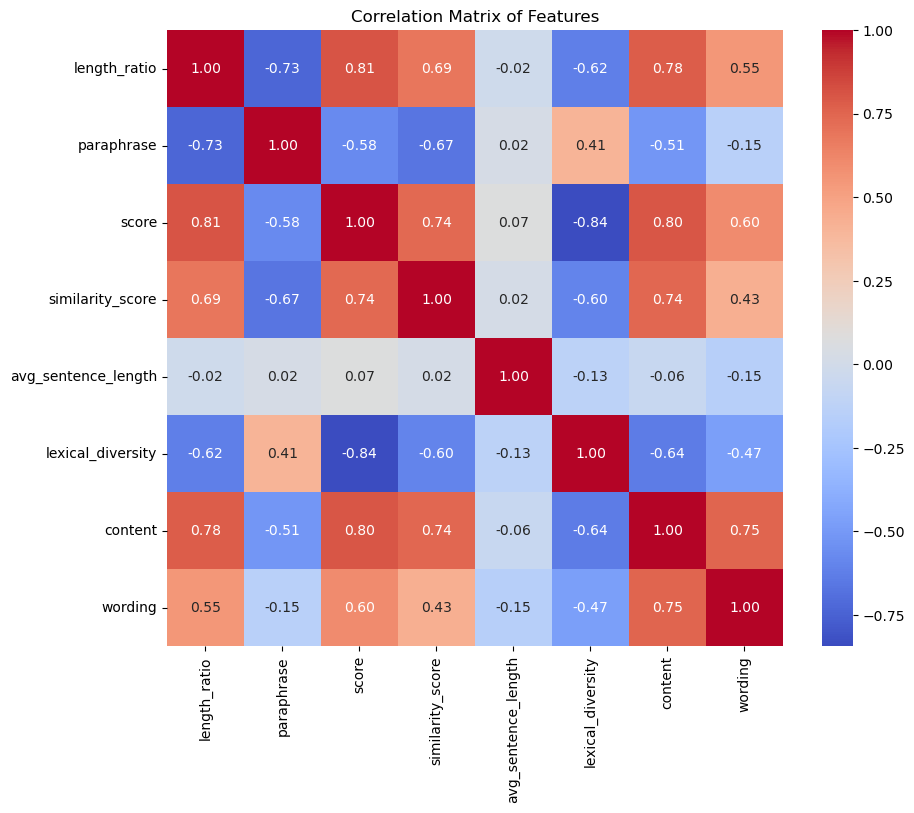

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate correlation matrix
corr = df_train[ALL_FEATURES + ["content", "wording"]].corr()
# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Matrix of Features')
plt.show()

## Build Model

In [12]:
from sklearn.linear_model import LinearRegression

model_content = LinearRegression().fit(df_train[CONTENT_FEATURES], df_train['content'])
model_wording = LinearRegression().fit(df_train[WORDING_FEATURES], df_train['wording'])

df_train['predicted_content'] = model_content.predict(df_train[CONTENT_FEATURES])
df_train['predicted_wording'] = model_wording.predict(df_train[WORDING_FEATURES])

df_test['content'] = model_content.predict(df_test[CONTENT_FEATURES])
df_test['wording'] = model_wording.predict(df_test[WORDING_FEATURES])

## Evaluation

In [13]:
from sklearn.metrics import r2_score

# Calculate R2 score for each model
r2_content = r2_score(df_train['content'], df_train['predicted_content'])
r2_wording = r2_score(df_train['wording'], df_train['predicted_wording'])

print(f"Content Model R2 Score: {r2_content}")
print(f"Wording Model R2 Score: {r2_wording}")


Content Model R2 Score: 0.7221892380172248
Wording Model R2 Score: 0.5008006188756884


In [14]:
import numpy as np

def compute_mcrmse(df):
    def rmse(actual, predictions):
        return np.sqrt(np.mean((actual - predictions)**2))

    rmse_content = rmse(df['content'], df['predicted_content'])
    rmse_wording = rmse(df['wording'], df['predicted_wording'])

    mcrmse = np.mean([rmse_content, rmse_wording])
    
    return mcrmse, rmse_content, rmse_wording



In [15]:
print("mcrmse")
print(compute_mcrmse(df_train))

mcrmse
(0.6409812217042844, 0.5500036264748479, 0.7319588169337209)


## Submit

In [16]:
df_test[['student_id', 'content', 'wording']].to_csv('submission.csv',index=False)
display(pd.read_csv('submission.csv'))

,student_id,content,wording
0,000000ffffff,4.692362,3.003592
1,222222cccccc,4.673716,2.991418
2,111111eeeeee,4.624762,2.959456
3,333333dddddd,4.633610,2.965233
